In [1]:
#!pip install opencv-python matplotlib imageio gdown tensorflow
import os
import cv2
import dlib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from typing import List
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import gdown
import imageio

In [2]:
file_id = '1shZ5PTNJdKv3Ms_QHSz-hHKGqkfPw6Np'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1shZ5PTNJdKv3Ms_QHSz-hHKGqkfPw6Np
From (redirected): https://drive.google.com/uc?id=1shZ5PTNJdKv3Ms_QHSz-hHKGqkfPw6Np&confirm=t&uuid=96498bba-012c-43cc-a1f4-e140046cc42c
To: /content/data.zip
100%|██████████| 423M/423M [00:09<00:00, 45.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

## Organizing video files and corresponding alignments

In [3]:

def organize_data(videos_dir, alignments_dir):
    video_files = []
    alignment_files = []

    # Iterate over files in the videos directory
    for file in os.listdir(videos_dir):
        video_path = os.path.join(videos_dir, file)

        # Check if the file is a video file
        if file.endswith(".mpg"):
            video_files.append(video_path)

            # Find the corresponding alignment file
            alignment_file = file.replace(".mpg", ".align")
            alignment_path = os.path.join(alignments_dir, alignment_file)

            if os.path.exists(alignment_path):
                alignment_files.append(alignment_path)
            else:
                print(f"Alignment file not found for video: {file}")

    # Sort the video and alignment files
    video_files.sort()
    alignment_files.sort()

    # Create a list of tuples (video_file, alignment_file)
    data_pairs = list(zip(video_files, alignment_files))

    return data_pairs


In [4]:
videos_dir = './data/s1'
alignments_dir = './data/alignments/s1'

data_pairs = organize_data(videos_dir, alignments_dir)

# Print the organized data pairs
for video_file, alignment_file in data_pairs:
    print(f"Video: {video_file}")
    print(f"Alignment: {alignment_file}")
    print()


Video: ./data/s1/bbaf2n.mpg
Alignment: ./data/alignments/s1/bbaf2n.align

Video: ./data/s1/bbaf3s.mpg
Alignment: ./data/alignments/s1/bbaf3s.align

Video: ./data/s1/bbaf4p.mpg
Alignment: ./data/alignments/s1/bbaf4p.align

Video: ./data/s1/bbaf5a.mpg
Alignment: ./data/alignments/s1/bbaf5a.align

Video: ./data/s1/bbal6n.mpg
Alignment: ./data/alignments/s1/bbal6n.align

Video: ./data/s1/bbal7s.mpg
Alignment: ./data/alignments/s1/bbal7s.align

Video: ./data/s1/bbal8p.mpg
Alignment: ./data/alignments/s1/bbal8p.align

Video: ./data/s1/bbal9a.mpg
Alignment: ./data/alignments/s1/bbal9a.align

Video: ./data/s1/bbas1s.mpg
Alignment: ./data/alignments/s1/bbas1s.align

Video: ./data/s1/bbas2p.mpg
Alignment: ./data/alignments/s1/bbas2p.align

Video: ./data/s1/bbas3a.mpg
Alignment: ./data/alignments/s1/bbas3a.align

Video: ./data/s1/bbaszn.mpg
Alignment: ./data/alignments/s1/bbaszn.align

Video: ./data/s1/bbaz4n.mpg
Alignment: ./data/alignments/s1/bbaz4n.align

Video: ./data/s1/bbaz5s.mpg
Alignment:

In [5]:

file_id = '1sJ-ujHfz9mykulBOa9cu5jZDQrfEOh4y'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'shape_predictor_68_face_landmarks.dat'

# Download the file
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1sJ-ujHfz9mykulBOa9cu5jZDQrfEOh4y
To: /content/shape_predictor_68_face_landmarks.dat
100%|██████████| 99.7M/99.7M [00:01<00:00, 63.1MB/s]


'shape_predictor_68_face_landmarks.dat'

## Processing lip regions from the videos

In [7]:

def load_video(path: str, predictor_path: str) -> List[float]:
    # Load the shape predictor model
    predictor = dlib.shape_predictor(predictor_path)

    # Load the dlib face detector
    detector = dlib.get_frontal_face_detector()

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = detector(gray)

        # Process each detected face
        for face in faces:
            # Get the facial landmarks
            landmarks = predictor(gray, face)

            # Extract the lip region coordinates
            lip_points = []
            for i in range(48, 68):
                x = landmarks.part(i).x
                y = landmarks.part(i).y
                lip_points.append((x, y))

            # Convert the lip points to a NumPy array
            lip_points = np.array(lip_points)

            # Calculate the bounding box of the lip region
            x_min, y_min = np.min(lip_points, axis=0)
            x_max, y_max = np.max(lip_points, axis=0)

            # Extract the lip region from the frame
            lip_region = frame[y_min:y_max, x_min:x_max]

            # Convert the lip region to grayscale
            lip_region = cv2.cvtColor(lip_region, cv2.COLOR_BGR2GRAY)

            # Resize the lip region to a fixed size
            lip_region = cv2.resize(lip_region, (64, 64))

            frames.append(lip_region)

    cap.release()

    # Convert frames to float32 and normalize
    frames = tf.cast(frames, tf.float32) / 255.0

    return frames


## Sample Visualization of the frame

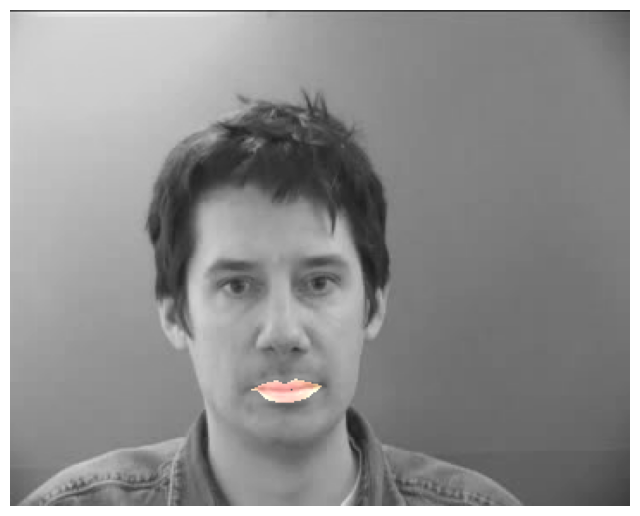

In [10]:

def visualize_lip_region(frame, predictor_path):
    # Load the shape predictor model
    predictor = dlib.shape_predictor(predictor_path)

    # Load the dlib face detector
    detector = dlib.get_frontal_face_detector()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = detector(gray)

    # Process each detected face
    for face in faces:
        # Get the facial landmarks
        landmarks = predictor(gray, face)

        # Extract the lip region coordinates
        lip_points = []
        for i in range(48, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            lip_points.append((x, y))

        # Convert the lip points to a NumPy array
        lip_points = np.array(lip_points)

        # Create a mask for the lip region
        mask = np.zeros_like(gray)
        cv2.fillPoly(mask, [lip_points], 255)

        # Create a colored lip region
        lip_region_color = cv2.bitwise_and(frame, frame, mask=mask)

        # Create a grayscale frame with the colored lip region
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
        result = cv2.addWeighted(gray_frame, 1, lip_region_color, 1, 0)

    return result

# Specify the path to the shape predictor model
predictor_path = './shape_predictor_68_face_landmarks.dat'

# Load a sample video frame
video_path = './data/s1/bbaf2n.mpg'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

# Visualize the lip region on the frame
frame_with_lip_region = visualize_lip_region(frame, predictor_path)

# Display the frame with the lip region highlighted
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame_with_lip_region, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## character-to-number and number-to-character mapping

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

char_to_num.get_vocabulary()

char_to_num(['v','i','v','e','k'])

num_to_char([22,9,22,5,11])

def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:

def create_dataset(data_pairs, predictor_path):
    videos = []
    alignments = []

    for video_file, alignment_file in data_pairs:
        video_frames = load_video(video_file, predictor_path)
        alignment_tokens = load_alignments(alignment_file)

        videos.append(video_frames)
        alignments.append(alignment_tokens)

    # Pad the video frames and alignments to the maximum length
    max_video_length = max(len(video) for video in videos)
    max_alignment_length = max(len(alignment) for alignment in alignments)

    padded_videos = []
    padded_alignments = []

    for video, alignment in zip(videos, alignments):
        # Pad video frames
        padding_frames = max_video_length - len(video)
        padded_video = tf.pad(video, [[0, padding_frames], [0, 0], [0, 0]])
        padded_videos.append(padded_video)

        # Pad alignments
        padding_tokens = max_alignment_length - len(alignment)
        padded_alignment = tf.pad(alignment, [[0, padding_tokens]])
        padded_alignments.append(padded_alignment)

    # Convert the padded videos and alignments to TensorFlow datasets
    video_dataset = tf.data.Dataset.from_tensor_slices(padded_videos)
    alignment_dataset = tf.data.Dataset.from_tensor_slices(padded_alignments)

    # Zip the video and alignment datasets
    dataset = tf.data.Dataset.zip((video_dataset, alignment_dataset))

    return dataset

In [ ]:
# Specify the path to the shape predictor model
predictor_path = './shape_predictor_68_face_landmarks.dat'

# Create the dataset
dataset = create_dataset(data_pairs, predictor_path)

# Get the total number of samples in the dataset
total_samples = len(data_pairs)

# Specify the split ratio
train_ratio = 0.8
train_samples = int(total_samples * train_ratio)

# Split the dataset into training and testing sets
train_dataset = dataset.take(train_samples)
test_dataset = dataset.skip(train_samples)


In [ ]:
# Reshape the video data to match the model architecture
train_dataset = train_dataset.map(lambda video, alignment: (tf.expand_dims(video, axis=-1), alignment))
test_dataset = test_dataset.map(lambda video, alignment: (tf.expand_dims(video, axis=-1), alignment))


# Define the maximum label length
max_label_length = 31
train_dataset = train_dataset.map(lambda video, alignment: (tf.expand_dims(video, axis=0), tf.reshape(alignment, (-1, max_label_length))))
test_dataset = test_dataset.map(lambda video, alignment: (tf.expand_dims(video, axis=0), tf.reshape(alignment, (-1, max_label_length))))



# Print the dataset information
print("Training Dataset:")
for video, alignment in train_dataset.take(1):
    print("Video shape:", video.shape)
    print("Alignment shape:", alignment.shape)

print("Testing Dataset:")
for video, alignment in test_dataset.take(1):
    print("Video shape:", video.shape)
    print("Alignment shape:", alignment.shape)





Training Dataset:
Video shape: (1, 75, 64, 64, 1)
Alignment shape: (1, 31)
Testing Dataset:
Video shape: (1, 75, 64, 64, 1)
Alignment shape: (1, 31)


In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


## Model Architecture

In [ ]:
'''

# Define the model architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 64, 64, 1), padding='same'))

model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

model.summary()

'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 64, 64, 128)   3584      
                                                                 
 activation (Activation)     (None, 75, 64, 64, 128)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 32, 32, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 32, 32, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 32, 32, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 16, 16, 256)   0         
 g3D)                                                   

## First Trained model(20 epochs)

In [ ]:
'''

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Define callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)

# Train the model
model.fit(train_dataset, epochs=20, callbacks=[checkpoint_callback, schedule_callback])

# Evaluate the model
model.evaluate(test_dataset)

import os
from google.colab import files

# Save the model
model_name = "lip_reading_model.h5"
model.save(model_name)

'''

Epoch 1/20
800/800 [==============================] - 156s 186ms/step - loss: 40.8275 - lr: 1.0000e-04
Epoch 2/20
800/800 [==============================] - 149s 186ms/step - loss: 39.4321 - lr: 1.0000e-04
Epoch 3/20
800/800 [==============================] - 150s 188ms/step - loss: 37.8681 - lr: 1.0000e-04
Epoch 4/20
800/800 [==============================] - 150s 187ms/step - loss: 35.9273 - lr: 1.0000e-04
Epoch 5/20
800/800 [==============================] - 150s 187ms/step - loss: 33.5567 - lr: 1.0000e-04
Epoch 6/20
800/800 [==============================] - 150s 188ms/step - loss: 31.7448 - lr: 1.0000e-04
Epoch 7/20
800/800 [==============================] - 151s 188ms/step - loss: 29.5178 - lr: 1.0000e-04
Epoch 8/20
800/800 [==============================] - 151s 188ms/step - loss: 27.9191 - lr: 1.0000e-04
Epoch 9/20
800/800 [==============================] - 151s 189ms/step - loss: 26.4712 - lr: 1.0000e-04
Epoch 10/20
800/800 [==============================] - 151s 189ms/step - 

22.113365173339844

## using the saved model for retraining (40 epochs)

In [ ]:
'''

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Load the saved model
model = load_model('lip_reading_model_20.h5', custom_objects={'CTCLoss': CTCLoss})

# Define callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)

# Continue training the model for an additional 20 epochs
model.fit(train_dataset, epochs=20, callbacks=[checkpoint_callback, schedule_callback])

# Evaluate the model on the test dataset
model.evaluate(test_dataset)


'''

Epoch 1/20
800/800 [==============================] - 165s 189ms/step - loss: 11.8660 - lr: 1.0000e-04
Epoch 2/20
800/800 [==============================] - 152s 190ms/step - loss: 11.3915 - lr: 1.0000e-04
Epoch 3/20
800/800 [==============================] - 150s 188ms/step - loss: 10.4867 - lr: 1.0000e-04
Epoch 4/20
800/800 [==============================] - 151s 188ms/step - loss: 9.8636 - lr: 1.0000e-04
Epoch 5/20
800/800 [==============================] - 150s 188ms/step - loss: 9.4729 - lr: 1.0000e-04
Epoch 6/20
800/800 [==============================] - 150s 188ms/step - loss: 9.0315 - lr: 1.0000e-04
Epoch 7/20
800/800 [==============================] - 150s 188ms/step - loss: 8.5841 - lr: 1.0000e-04
Epoch 8/20
800/800 [==============================] - 150s 188ms/step - loss: 8.4889 - lr: 1.0000e-04
Epoch 9/20
800/800 [==============================] - 151s 189ms/step - loss: 7.9639 - lr: 1.0000e-04
Epoch 10/20
800/800 [==============================] - 150s 187ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## using the saved model for retraining (60 epochs)

In [ ]:

# Load the saved model
model = load_model('lip_reading_model_40.h5', custom_objects={'CTCLoss': CTCLoss})

# Define callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)

# Continue training the model for an additional 20 epochs
model.fit(train_dataset, epochs=20, callbacks=[checkpoint_callback, schedule_callback])

# Evaluate the model on the test dataset
model.evaluate(test_dataset)



Epoch 1/20
800/800 [==============================] - 156s 178ms/step - loss: 4.2920 - lr: 1.0000e-04
Epoch 2/20
800/800 [==============================] - 147s 184ms/step - loss: 4.1711 - lr: 1.0000e-04
Epoch 3/20
800/800 [==============================] - 147s 184ms/step - loss: 3.7882 - lr: 1.0000e-04
Epoch 4/20
800/800 [==============================] - 146s 183ms/step - loss: 3.6558 - lr: 1.0000e-04
Epoch 5/20
800/800 [==============================] - 147s 184ms/step - loss: 4.0371 - lr: 1.0000e-04
Epoch 6/20
800/800 [==============================] - 147s 184ms/step - loss: 3.6399 - lr: 1.0000e-04
Epoch 7/20
800/800 [==============================] - 147s 184ms/step - loss: 3.6537 - lr: 1.0000e-04
Epoch 8/20
800/800 [==============================] - 147s 184ms/step - loss: 3.2348 - lr: 1.0000e-04
Epoch 9/20
800/800 [==============================] - 147s 184ms/step - loss: 3.5438 - lr: 1.0000e-04
Epoch 10/20
800/800 [==============================] - 147s 184ms/step - loss: 2.9

41.81267547607422

In [ ]:
import os
from google.colab import files


# Save the updated model
model_name = "lip_reading_model_60.h5"
model.save(model_name)

# Download the model
files.download(model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Function to decode the predictions
def decode_predictions(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    results = tf.keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_texts = decode_predictions(predictions)

# Print the original and predicted texts
for (video, alignment), predicted_text in zip(test_dataset, predicted_texts):
    original_text = tf.strings.reduce_join(num_to_char(alignment)).numpy().decode("utf-8")
    print(f"Original Text: {original_text}")
    print(f"Predicted Text: {predicted_text}")
    print()


200/200 [==============================] - 11s 57ms/step
Original Text: set blue with o one soon
Predicted Text: set blue in o one soon

Original Text: set blue with o two please
Predicted Text: set blue ith f twor please

Original Text: set blue with o three again
Predicted Text: set blue in f thre again

Original Text: set blue with o zero now
Predicted Text: set blue with u tewo now

Original Text: set blue with u four now
Predicted Text: set blue it t four now

Original Text: set blue with u five soon
Predicted Text: set blue in five soon

Original Text: set blue with u six please
Predicted Text: set blue with t thr please

Original Text: set blue with u seven again
Predicted Text: set blue in z seven again

Original Text: set green at c two now
Predicted Text: lay green in l two now

Original Text: set green at c three soon
Predicted Text: bin green it k three soon

Original Text: set green at c four sp please
Predicted Text: lay green at x four please

Original Text: set green at

In [ ]:

def calculate_accuracy(original_texts, predicted_texts):
    total_characters = 0
    correct_characters = 0

    for original_text, predicted_text in zip(original_texts, predicted_texts):
        total_characters += len(original_text)
        correct_characters += sum(1 for a, b in zip(original_text, predicted_text) if a == b)

    accuracy = correct_characters / total_characters
    return accuracy


# Get the original texts
original_texts = []
for _, alignment in test_dataset:
    original_text = tf.strings.reduce_join(num_to_char(alignment)).numpy().decode("utf-8")
    original_texts.append(original_text)

# Calculate the accuracy
accuracy = calculate_accuracy(original_texts, predicted_texts)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5736


## Predictions

In [ ]:

# Load the shape predictor and the trained model
predictor_path = './shape_predictor_68_face_landmarks.dat'
model_path = 'lip_reading_model_60.h5'
predictor = dlib.shape_predictor(predictor_path)
detector = dlib.get_frontal_face_detector()
model = load_model(model_path, custom_objects={'CTCLoss': CTCLoss})

In [ ]:
def load_video_and_predict(path: str, frame_count=75):
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            lip_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)])
            x_min, y_min = np.min(lip_points, axis=0)
            x_max, y_max = np.max(lip_points, axis=0)
            lip_region = frame[y_min:y_max, x_min:x_max]
            lip_region = cv2.cvtColor(lip_region, cv2.COLOR_BGR2GRAY)
            lip_region = cv2.resize(lip_region, (64, 64))
            frames.append(lip_region)
    cap.release()

    # Adjust the number of frames to match the model's expected input
    frames = frames[:frame_count]
    while len(frames) < frame_count:
        frames.append(np.zeros((64, 64), dtype=np.float32))

    frames = np.array(frames).astype('float32') / 255.0
    frames = np.expand_dims(frames, axis=-1)
    frames = np.expand_dims(frames, axis=0)
    return frames

def decode_predictions(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    results = tf.keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [ ]:

video_path = './lbij7s.mpg'
video_frames = load_video_and_predict(video_path)
predictions = model.predict(video_frames)

predicted_text = decode_predictions(predictions)
print("Predicted Text:", predicted_text)


1/1 [==============================] - 0s 102ms/step
Predicted Text: ['lay blue in j seven soon']


In [ ]:

video_path = './lbwk9s.mpg'
video_frames = load_video_and_predict(video_path)
predictions = model.predict(video_frames)

predicted_text = decode_predictions(predictions)
print("Predicted Text:", predicted_text)


1/1 [==============================] - 0s 110ms/step
Predicted Text: ['lay blue with k nine soon']
